In [63]:
"""Wine Quality Prediction —
A machine learning project using Random Forest and XGBoost 
to predict wine quality based on physicochemical properties.
Includes both regression (predicting scores) and classification (good/bad quality) 
approaches with data preprocessing, EDA, and performance visualization."""

'Wine Quality Prediction —\nA machine learning project using Random Forest and XGBoost \nto predict wine quality based on physicochemical properties.\nIncludes both regression (predicting scores) and classification (good/bad quality) \napproaches with data preprocessing, EDA, and performance visualization.'

### IMPORT LIBRARIES

In [56]:
# Basic data handling
import pandas as pd            
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model training and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Model persistence
import joblib

# XGBoost (optional)
try:
    from xgboost import XGBRegressor, XGBClassifier
    XGB_OK = True
except ImportError:
    XGB_OK = False
    print("⚠️ XGBoost not installed, skipping XGBoost models.")

### LOAD DATASET

In [5]:
# Load CSV

df = pd.read_csv("WineQT.csv") 

In [7]:
# Basic info

print("Shape:", df.shape)
df.head()

Shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [9]:
# Column types

print(df.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object


In [11]:
# Missing values

print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64


In [13]:
# Summary statistics

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


### EDA 

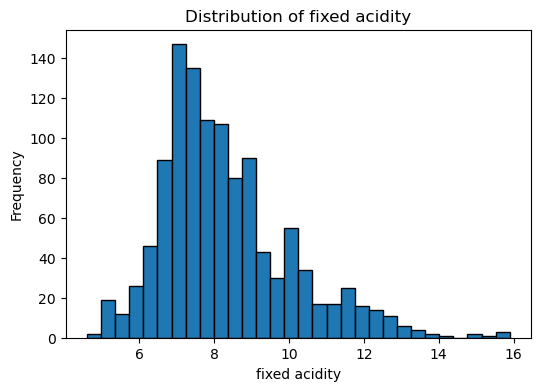

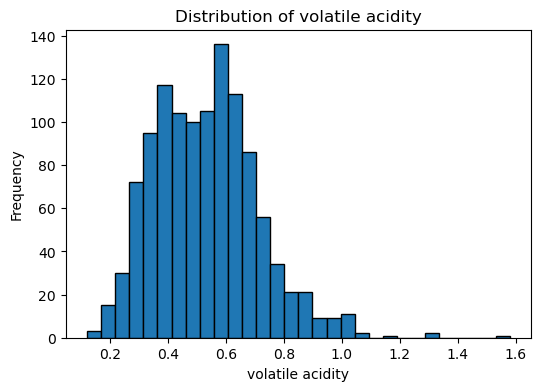

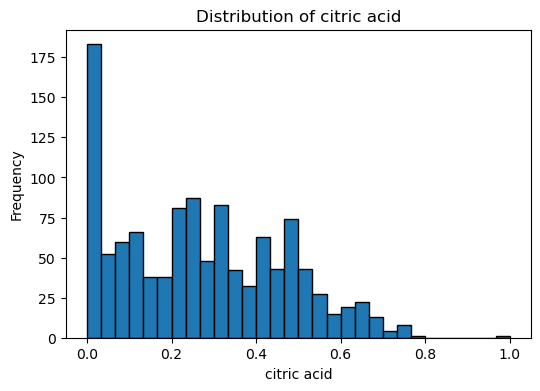

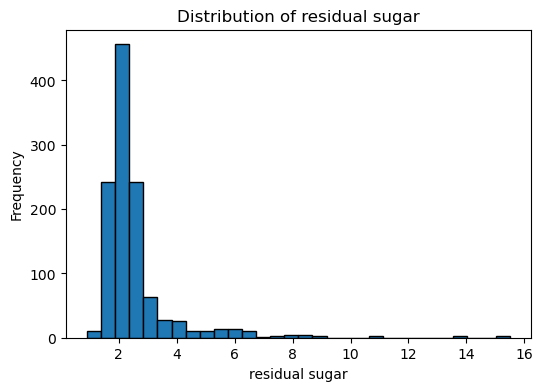

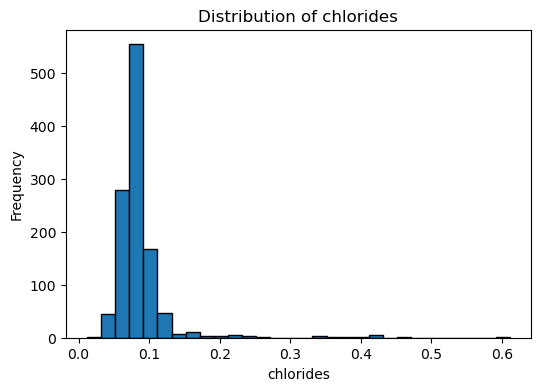

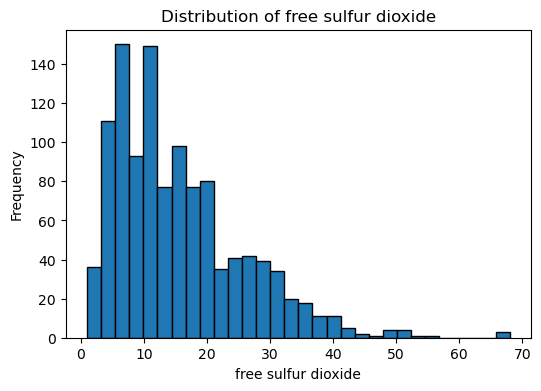

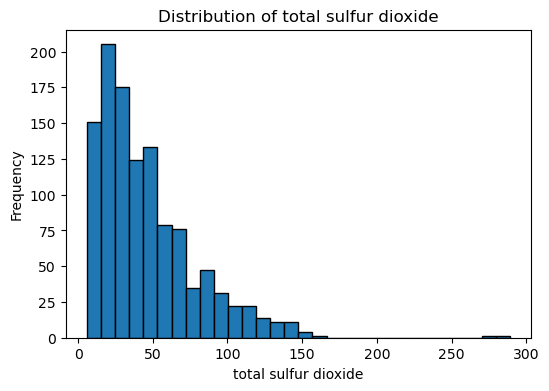

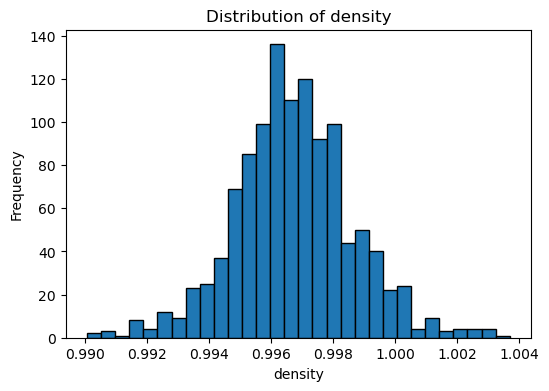

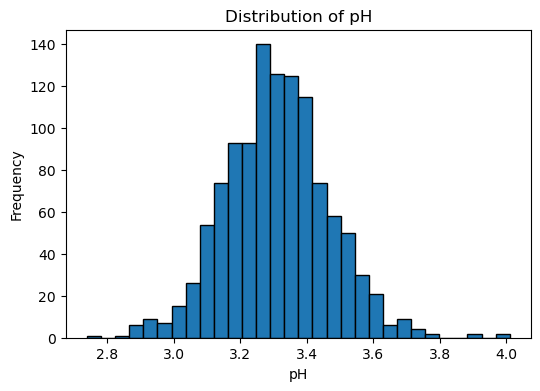

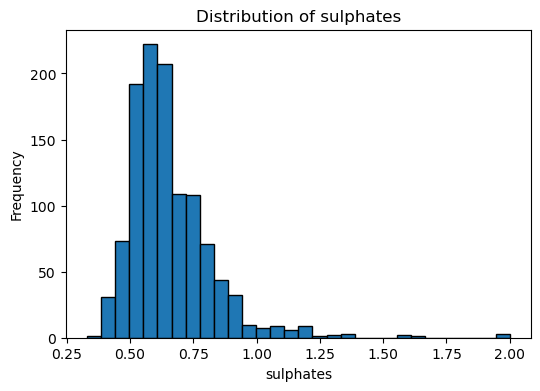

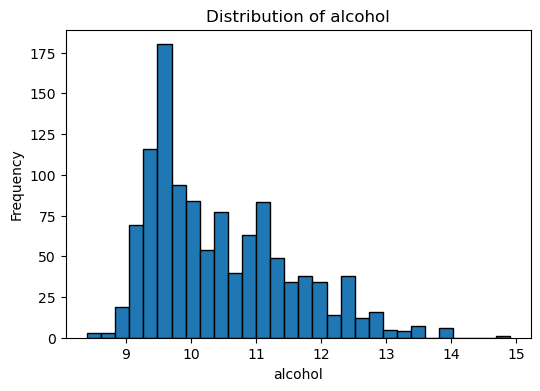

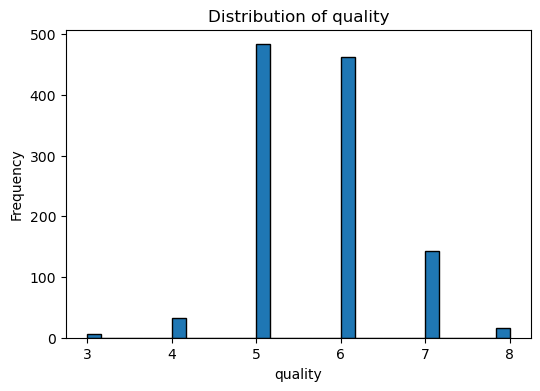

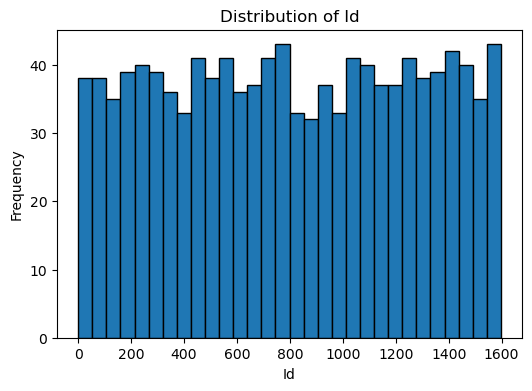

In [16]:
# Plot histograms for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

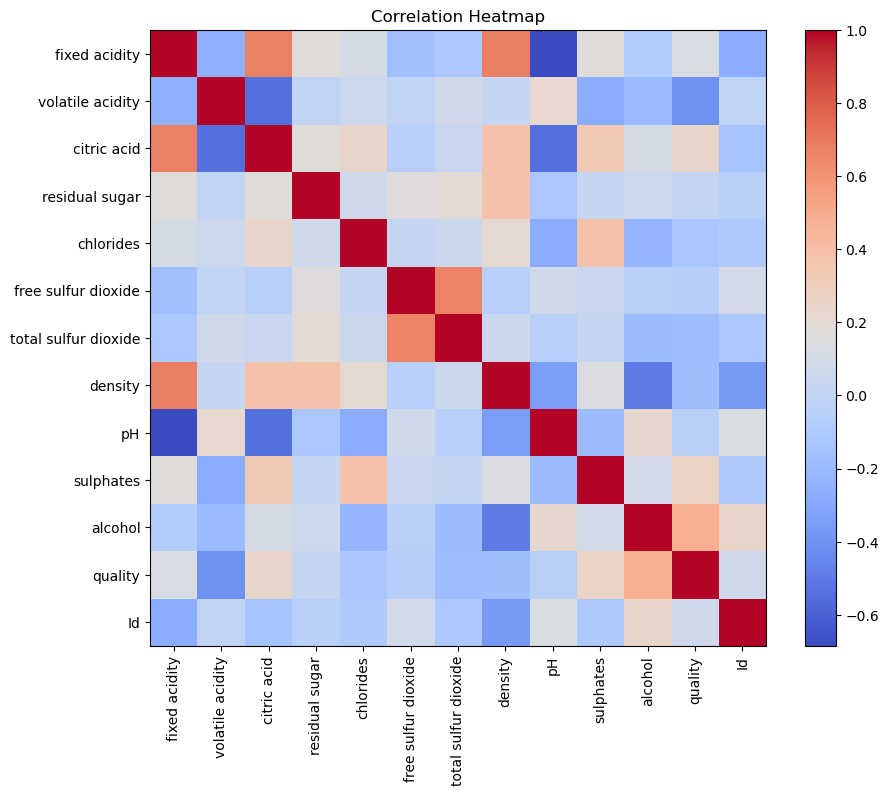

In [18]:
# CORRELATION HEATMAP

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()

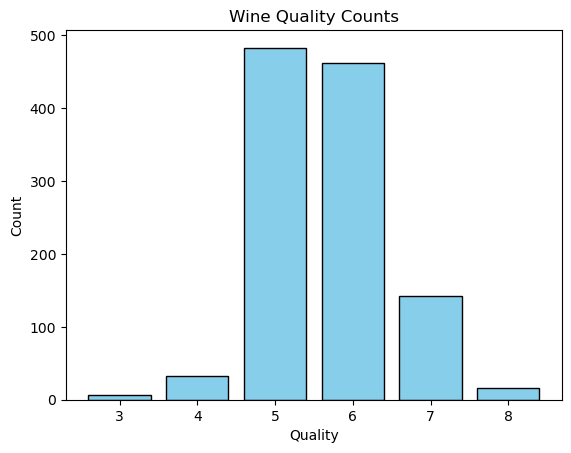

In [20]:
# EDA QUALITY COUNT

quality_counts = df["quality"].value_counts().sort_index()

plt.bar(quality_counts.index, quality_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Wine Quality Counts")
plt.show()

###  Features & target for regression

In [23]:
X = df.drop(columns=["quality"])
y_reg = df["quality"]  # Continuous target for regression

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

### Regression: Random Forest

In [26]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_r, y_train_r)

y_pred_rf = rf_reg.predict(X_test_r)

print("Random Forest Regression Metrics:")
print("MAE:", mean_absolute_error(y_test_r, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf)))
print("R²:", r2_score(y_test_r, y_pred_rf))

Random Forest Regression Metrics:
MAE: 0.4109170305676856
RMSE: 0.5458689639136779
R²: 0.46453299294085415


### Regression: XGBoost

In [29]:
if XGB_OK:
    xgb_reg = XGBRegressor(random_state=42, objective="reg:squarederror")
    xgb_reg.fit(X_train_r, y_train_r)

    y_pred_xgb = xgb_reg.predict(X_test_r)

    print("XGBoost Regression Metrics:")
    print("MAE:", mean_absolute_error(y_test_r, y_pred_xgb))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_xgb)))
    print("R²:", r2_score(y_test_r, y_pred_xgb))
else:
    print("Skipping XGBoost Regression — Not Installed.")

XGBoost Regression Metrics:
MAE: 0.40091581427894823
RMSE: 0.5798615958692847
R²: 0.395766771798973


### Features & target for classification

In [32]:
# Binary classification: Good (1) if quality >= 7, else Not Good (0)

y_cls = (df["quality"] >= 7).astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_cls, test_size=0.2, stratify=y_cls, random_state=42
)

### Classification: Random Forest

In [35]:
rf_cls = RandomForestClassifier(random_state=42)
rf_cls.fit(X_train_c, y_train_c)

y_pred_rf_c = rf_cls.predict(X_test_c)


In [37]:
print("Random Forest Classification Metrics:")
print("Accuracy:", accuracy_score(y_test_c, y_pred_rf_c))
print("Precision:", precision_score(y_test_c, y_pred_rf_c))
print("Recall:", recall_score(y_test_c, y_pred_rf_c))
print("F1 Score:", f1_score(y_test_c, y_pred_rf_c))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_rf_c))

Random Forest Classification Metrics:
Accuracy: 0.9170305676855895
Precision: 0.76
Recall: 0.59375
F1 Score: 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       197
           1       0.76      0.59      0.67        32

    accuracy                           0.92       229
   macro avg       0.85      0.78      0.81       229
weighted avg       0.91      0.92      0.91       229



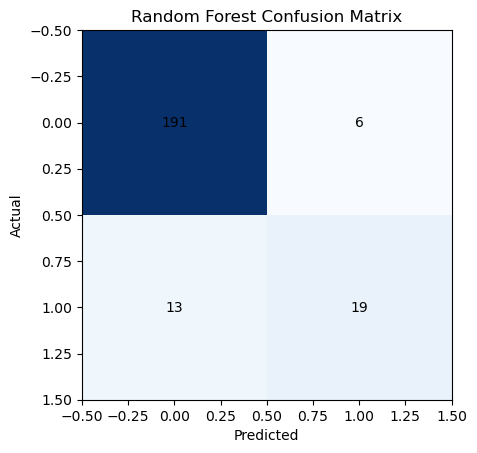

In [39]:
# Confusion matrix

cm = confusion_matrix(y_test_c, y_pred_rf_c)
plt.imshow(cm, cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.show()

### Classification: XGBoost 

In [42]:
if XGB_OK:
    xgb_cls = XGBClassifier(random_state=42, objective="binary:logistic", eval_metric="logloss")
    xgb_cls.fit(X_train_c, y_train_c)

    y_pred_xgb_c = xgb_cls.predict(X_test_c)
    

In [46]:
print("XGBoost Classification Metrics:")
print("Accuracy:", accuracy_score(y_test_c, y_pred_xgb_c))
print("Precision:", precision_score(y_test_c, y_pred_xgb_c))
print("Recall:", recall_score(y_test_c, y_pred_xgb_c))
print("F1 Score:", f1_score(y_test_c, y_pred_xgb_c))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_xgb_c))

XGBoost Classification Metrics:
Accuracy: 0.9126637554585153
Precision: 0.75
Recall: 0.5625
F1 Score: 0.6428571428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       197
           1       0.75      0.56      0.64        32

    accuracy                           0.91       229
   macro avg       0.84      0.77      0.80       229
weighted avg       0.91      0.91      0.91       229



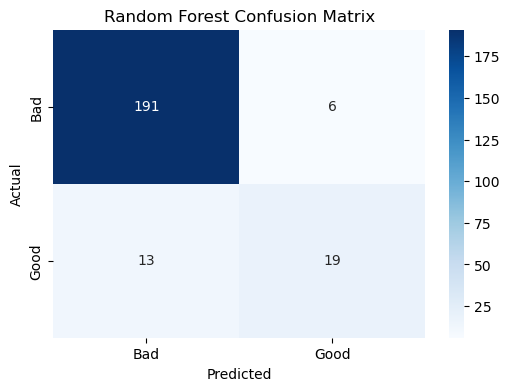

In [58]:
# CONFUSION MATRIX PLOT

cm = confusion_matrix(y_test_c, y_pred_rf_c)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Random Forest Confusion Matrix")
plt.show()

### SAVE MODEL

In [61]:
joblib.dump(rf_reg, "rf_regressor.joblib")
if XGB_OK:
    joblib.dump(xgb_reg, "xgb_regressor.joblib")

joblib.dump(rf_cls, "rf_classifier.joblib")
if XGB_OK:
    joblib.dump(xgb_cls, "xgb_classifier.joblib")

print("Models saved successfully!")

Models saved successfully!
